In [3]:
!pip install fastai
!pip install torchvision
!pip install --upgrade pillow

  Using cached fastai-2.7.16-py3-none-any.whl.metadata (9.1 kB)
  Using cached fastdownload-0.0.7-py3-none-any.whl.metadata (5.5 kB)
  Using cached fastcore-1.5.55-py3-none-any.whl.metadata (3.5 kB)
  Using cached torchvision-0.19.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.0 kB)
  Using cached pandas-2.2.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (19 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached PyYAML-6.0.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached fastprogress-1.0.3-py3-none-any.whl.metadata (5.6 kB)
  Using cached pillow-10.4.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.2 kB)
  Using cached scipy-1.14.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (60 kB)
  Using cached spacy-3.7.5-cp312-cp312-macosx_11_0_arm64.whl.metadata (27 kB)
  Using cached torch-2.4.0-cp312-none-macosx_11_0_arm64.whl.metadata (26 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0

In [8]:
from fastai.vision.all import *
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F233210%2F497253%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240804%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240804T090004Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D81fd067b951119fa321cb612e5b136db72597b30c71e1f8ac3742ae3b5ca20041fd01c977de8903dbb441398d8e840810c312f7dd07304574a1ccfa51a40394e3d4d8346ad3d42d216cb960fca8464f1635dab0164e532ed4ff038d70fbeffb21e85f0cd15cc8c169deae9292a09a08b516c449f53f16a37a0e76945de2232b77d600a9309cab777203f70460a0281688b4f02aaa39943dba42e1b3ca38b72fd594ce68c75e187e3f0f68b278a99fb60ed2bbce12452f980014e8c117f7f6922a84171f320d734ad7aa95fef2104a994a570235718e09c947977dc50ba53447dcac0e49fef0d88cfd744d38d71f2b17b684c98b112f7015bee1f870a3731b218'

KAGGLE_INPUT_PATH='./kaggle/input'
KAGGLE_WORKING_PATH='./kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 447914276 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


In [9]:
path = Path('./kaggle/input/dataset/DATASET')
path.ls()

(#2) [Path('kaggle/input/dataset/DATASET/TEST'),Path('kaggle/input/dataset/DATASET/TRAIN')]

Classes: 
 ['O', 'R']


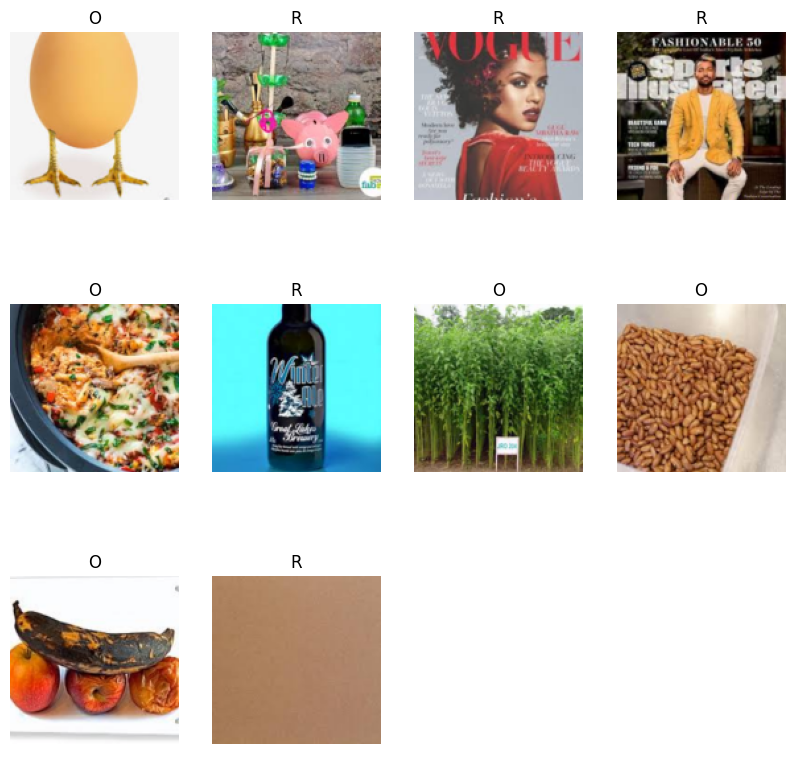

In [10]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='TRAIN', valid_name='TEST'),
    get_y=parent_label,
    item_tfms=Resize(128),
    batch_tfms=Normalize.from_stats(*imagenet_stats)
)

dls = dblock.dataloaders(path, bs=32, num_workers=0)
print(f'Classes: \n {dls.vocab}')
dls.show_batch(max_n=10, figsize=(10,10))

/opt/homebrew/anaconda3/envs/fastai/lib/python3.12/site-packages/fastai/learner.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=de

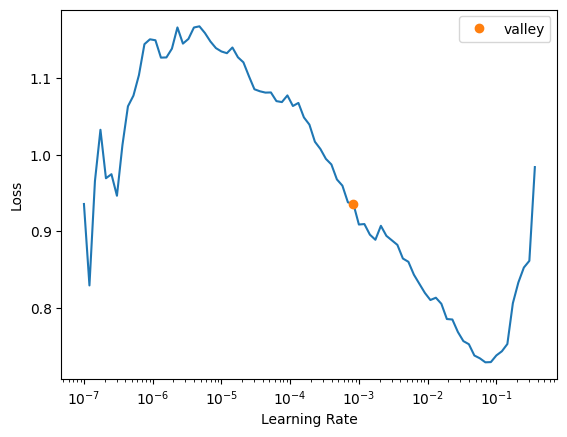

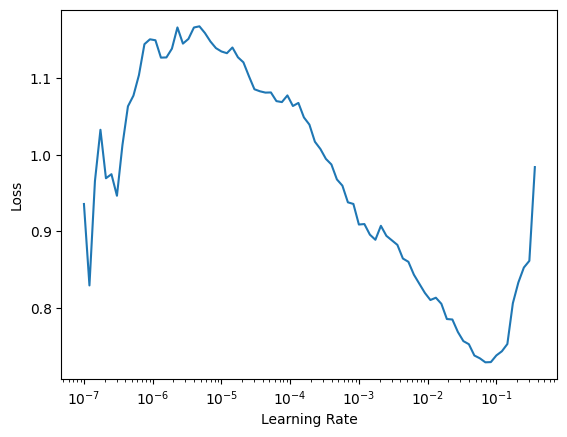

In [13]:
learn = vision_learner(dls, resnet50, metrics=accuracy, model_dir='/tmp/model/')
learn.lr_find()
learn.recorder.plot_lr_find()

In [14]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.274703,0.243690,0.902109,09:49


epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.fine_tune(5, base_lr=slice(1e-6,1e-4))
learn.recorder.plot_losses()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9, figsize=(20,20))

In [ ]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=75)
learn.save('waste-clf-fastai-v2')